<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/MiniProjects/M7_NB_MiniProject_4_End_to_End_Analytics_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: End-to-end analytics application using Pyspark

## Problem Statement

Perform sentiment classification by analyzing the tweets data with Pyspark

## Learning Objectives

At the end of the mini-project, you will be able to :

* analyze the text data using pyspark
* derive the insights and visualize the data
* implement feature extraction and classify the data
* train the classification model and deploy

### Dataset

The dataset chosen for this mini-project is **[Twitter US Airline Sentiment](https://data.world/socialmediadata/twitter-us-airline-sentiment)**. It is a record of tweets about airlines in the US. It was created by scraping Twitter data from February 2015. Contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").  Along with other information, it contains ID of a Tweet, the sentiment of a tweet ( neutral, negative and positive), reason for a negative tweet, name of airline and text of a tweet.

## Information

The airline industry is a very competitive market that has grown rapidly in the past 2 decades. Airline companies resort to traditional customer feedback forms which in turn are very tedious and time consuming. This is where Twitter data serves as a good source to gather customer feedback tweets and perform sentiment analysis. This dataset comprises of tweets for 6 major US Airlines and a multi-class classification can be performed to categorize the sentiment (neutral, negative, positive). For this mini-project we will start with pre-processing techniques to clean the tweets and then represent these tweets as vectors. A classification algorithm will be used to predict the sentiment for unseen tweets data. The end-to-end analytics will be performed using Pyspark.

## Grading = 10 Points

Install Spark

In [1]:
# install java
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

**Note: The above code cell will take around 8 mins 30 secs for execution.**


### Set the os environment

In [2]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

### Install findspark

In [3]:
# install findspark using pip
!pip install -q findspark

#### Install Pyspark

In [4]:
#@title Install packages and download the dataset
!pip -qq install pyspark
!pip -qq install handyspark
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/US_Airline_Tweets.csv
print("Packages installed successfully and dataset downloaded!!")

Packages installed successfully and dataset downloaded!!


In [5]:
#from handyspark import *
import findspark
findspark.init()

### Install numpy==1.26.0

In [6]:
!pip -qq install mxnet-mkl==1.6.0 numpy==1.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 56.0 MB/s eta 0:00:00


In [7]:
import numpy as np
#np.bool = np.bool_

### Import Handyspark

In [8]:
#Downgrade Numpy to 1.23.1
!pip install numpy==1.23.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 62.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.23.1-cp311-cp311-linux_x86_64.whl size=19731092 sha256=1b78c4c2cf46fcfdbf8171b3cedb45d99b17eaf43042b51516118e9c98733721
  Stored in directory: /root/.cache/pip/wheels/54/67/ec/c3e57b4b51328fb39dd4d63906b0d3bd37a312508e5922682f
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.10.2 requires numpy>=1.23.2; python_version >= "3.11", but you have numpy 1.23.1 which is incompatible.
opencv-contrib-python 4.10.0.84 requires numpy>=1.2

###After running the above code cell please restart the session

In [1]:
import handyspark

#### Import required packages

In [2]:
import os
import numpy as np
import pandas as pd
# fixes issue with seaborn hiding fliers on boxplot
import matplotlib as mpl
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from handyspark import *
import seaborn as sns
from matplotlib import pyplot as plt
import re
import string
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.types import ArrayType, StringType
import warnings
warnings.filterwarnings("ignore")

In [3]:
# NLTK imports
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Data Loading

#### Start a Spark Session

Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0. It provides a way to interact with various Spark functionalities, with a lesser number of constructs.

In [4]:
# YOUR CODE HERE
spark = SparkSession.builder.appName("MiniProject").getOrCreate()

#### Load the data and infer the schema

To load the dataset use the `read.csv` with `inferSchema` and `header` as parameters.

In [5]:
path = "/content/US_Airline_Tweets.csv"
# YOUR CODE HERE
df = spark.read.csv(path, header=True, inferSchema=True)

### EDA & Visualization ( 2 points)

#### Visualize the horizontal barplot of airline_sentiment (positive, negative, neutral)

Convert the data to handyspark and remove the other records from the column except 3 values mentioned above and plot the graph

<Axes: title={'center': 'airline_sentiment'}, xlabel='airline_sentiment'>

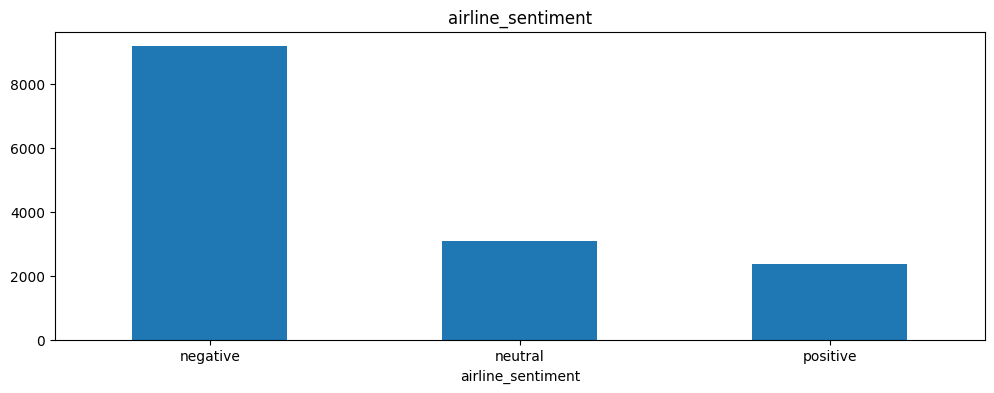

In [24]:
# YOUR CODE HERE
hdf = df.toHandy()
# Filter
hdf = hdf.filter(hdf['airline_sentiment'].isin(['positive', 'negative', 'neutral']))

# Plot horizontal barplot
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
hdf.cols['airline_sentiment'].hist(ax=axs)

In [10]:
hdf.show()

+--------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+---------------+-------------------+-------------+--------------------+-----------+--------------------+--------------------+--------------------+
|            tweet_id|airline_sentiment|airline_sentiment_confidence|negativereason|negativereason_confidence|       airline|airline_sentiment_gold|           name|negativereason_gold|retweet_count|                text|tweet_coord|       tweet_created|      tweet_location|       user_timezone|
+--------------------+-----------------+----------------------------+--------------+-------------------------+--------------+----------------------+---------------+-------------------+-------------+--------------------+-----------+--------------------+--------------------+--------------------+
|  570306133677760513|          neutral|                         1.0|          NULL|                     NULL|Virgi

#### Plot the number of tweets received for each airline

<Axes: title={'center': 'airline'}, xlabel='airline'>

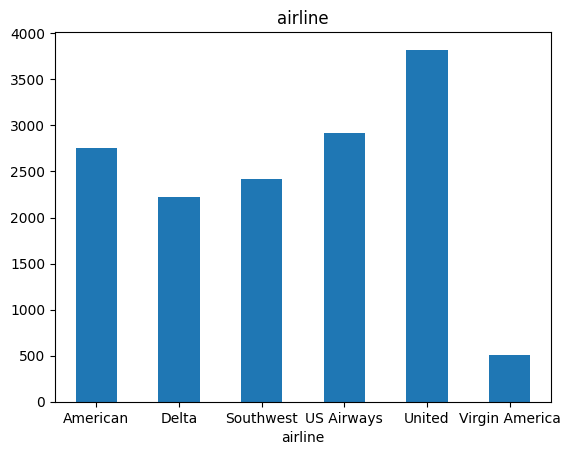

In [25]:
# YOUR CODE HERE
hdf.cols['airline'].hist()

#### Visualize a stacked barchart of 6 US airlines and 3 sentiments on each bar

* Group the sentiment counts for each airline. [hint](https://github.com/dvgodoy/handyspark#stratify)

* Display the count corresponding to each sentiment in each bar. [hint](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/M5_NB_MiniProject_4_End_to_End_Analytics_Pyspark%20priteshbgohil_medium_com_stacked_bar_chart_in_python.pdf)

In [33]:
# YOUR CODE HERE
# Group sentiment count for each airline
# hdf.stratify('airline').cols['airline_sentiment'].hist()



INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.


KeyError: 'airline'

#### Visualize the horizontal barplot of negative reasons

In [ ]:
# YOUR CODE HERE

### Pre-processing (3 points)

#### Check the null values and drop the records where the text value is null

In [ ]:
# YOUR CODE HERE

#### Fill the null values with 0 in all the columns except the target

The target should not be empty. Ensure that all features are integer type, convert if needed.

In [ ]:
# YOUR CODE HERE

#### Preprocessing and cleaning the tweets

* Convert the text to lower case
* Remove usernames, hashtags and links from the text (tweets)

In [ ]:
# YOUR CODE HERE

#### Tokenize each sentence into words using nltk word tokenizer

In [ ]:
# YOUR CODE HERE

#### Remove the stopwords from tokenized words

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)

In [ ]:
# YOUR CODE HERE

#### Apply Lemmatization to the words

In [ ]:
# YOUR CODE HERE

### Feature Extraction (3 points)

Create the useful features from the text column to train the model

For example:
* Length of the tweet
* No. of hashtags in the tweet starting with '#'
* No. of mentions in the tweet starting with '@'

Hint: create a new column for each of the above features

In [ ]:
# YOUR CODE HERE

#### Get the features by applying CountVectorizer
CountVectorizer converts the list of tokens to vectors of token counts. See the [documentation](https://spark.apache.org/docs/latest/ml-features.html#countvectorizer) for details.

In [ ]:
# YOUR CODE HERE

#### Encode the labels

Using the `udf` function encode the string values of *airline_sentiment* to integers.

In [ ]:
def LabelEncoder(x):
    if x == 'positive':
        return 0
    elif x == 'negative':
        return 1
    return 2

# YOUR CODE HERE

### Train the classifier the evaluate (1 point)

#### Create vector assembler with the selected features to train the model

In [ ]:
# YOUR CODE HERE

#### Arrange features and label and split them into train and test.

In [ ]:
# YOUR CODE HERE

#### Train the model with train data and make predictions on the test data

For classification of text data, implement NaiveBayes classifier. It is a probabilistic machine learning model.

For more information about **NaiveBayes Classifier**, click [here](https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes)

In [ ]:
nb = NaiveBayes(featuresCol='features', labelCol='labels')
# Fit the model with train data
model = nb.fit(train_data)

In [ ]:
# get the predictions
# YOUR CODE HERE

#### Evaluate the model and find the accuracy

Compare the labels and predictions and find how many are correct.

To find the accuracy, get the count of correct predictions from test data and divide by the total amount of test dataset.

**Hint:** convert the predictions dataframe to pandas and compare with labels

In [ ]:
# YOUR CODE HERE

As a next phase of implementation, we will implement logistic regression model.

### Implementing logistic regression.

For more information about logistic regression, click upon this [button](https://spark.apache.org/docs/2.3.1/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression) to proceed to spark's documentation of logistic regression.

In [ ]:
# Importing the necessary libraries
from pyspark.ml.classification import LogisticRegression
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Create a features column using VectorAssembler with multiple input columns like 'rawFeatures', 'airline_sentiment_confidence', and others?
# YOUR CODE HERE

In [ ]:
# Create an object of stringindexer
# YOUR CODE HERE

In [ ]:
# Create output column for labels or target variable.
# YOUR CODE HERE

In [ ]:
# Split the data into train and test
# YOUR CODE HERE

In [ ]:
# Create a Logistic Regression model object with specified parameters like maxIter=20, regParam=0.3, and elasticNetParam=0
# YOUR CODE HERE

In [ ]:
# Fit a Logistic Regression model to the training dataset using the fit method on the train data
# YOUR CODE HERE

### Making predictions and evaluating the model

In [ ]:
# Generate predictions on the test dataset
# YOUR CODE HERE

In [ ]:
# Create a MulticlassClassificationEvaluator object to evaluate predictions using the "prediction" column
# YOUR CODE HERE

In [ ]:
# Calculate the accuracy of predictions using the evaluate method from the MulticlassClassificationEvaluator
# YOUR CODE HERE

In [ ]:
# Print accuracy
# YOUR CODE HERE

# Gradio Implementation (1 point)

In [ ]:
!pip -q install gradio==3.41.2

In [ ]:
import gradio as gr

### Making predictions using NaiveBayes

In [ ]:
def make_prediction_using_NaiveBayes(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  df1 = df1.withColumn('UserTweet',words(df1['UserTweet']))
  df1 = df1.withColumn("wordss", word_udf("UserTweet"))
  df1 = df1.withColumn("wordss", punct_udf1("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))
  df1 = df1.withColumn("wordss", lem("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))

  df1 = df1.withColumn('tweet_length', length(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_hashtags', num_hashtags(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_mentions', num_mentions(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('PunctCount',punctCount(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('typePunct',typePunct(df1['UserTweet']).astype('int'))
  make  = udf(lambda x : 0)
  df1 = df1.withColumn('negativereason_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('airline_sentiment_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('retweet_count',make(df1['UserTweet']).astype('int'))
  df1_featured = count_model.transform(df1)
  test_features = featureassembler.transform(df1_featured)
  test_predict = model.transform(test_features)
  df_res = test_predict.select('prediction').toPandas()
  pred = df_res.prediction.values[0]

  if pred == 0:
    return "Positive tweet!"
  elif pred == 1:
    return "Negative Tweet!"
  return "Neutral tweet"

In [ ]:
# Make a prediction using make_prediction_using_NaiveBayes for the text "It was a bad approach"
# YOUR CODE HERE

### Making predictions using LogisticRegression

In [ ]:
def make_prediction_using_LogReg(user_input):
  df1 = spark.createDataFrame([ (1, user_input)],['Id', 'UserTweet'])

  df1 = df1.withColumn('UserTweet',words(df1['UserTweet']))
  df1 = df1.withColumn("wordss", word_udf("UserTweet"))
  df1 = df1.withColumn("wordss", punct_udf1("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))
  df1 = df1.withColumn("wordss", lem("wordss"))
  df1 = df1.withColumn("wordss", array_udf("wordss"))

  df1 = df1.withColumn('tweet_length', length(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_hashtags', num_hashtags(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('num_mentions', num_mentions(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('PunctCount',punctCount(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('typePunct',typePunct(df1['UserTweet']).astype('int'))
  make  = udf(lambda x : 0)
  df1 = df1.withColumn('negativereason_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('airline_sentiment_confidence',make(df1['UserTweet']).astype('int'))
  df1 = df1.withColumn('retweet_count',make(df1['UserTweet']).astype('int'))
  df1_featured = count_model.transform(df1)
  predictions = lrModel.transform(assembler.transform(df1_featured))
  df_res = predictions.select('prediction').toPandas()

  pred = df_res.prediction.values[0]

  if pred == 0:
    return "Positive tweet!"
  elif pred == 1:
    return "Negative Tweet!"
  return "Neutral tweet"

In [ ]:
# Make a prediction using make_prediction_using_LogReg "It was a bad approach"
# YOUR CODE HERE

### Launching Gradio application

Deployment is done for both the models:
1. Naive bayes
2. Logistic regression



Let's integrate all the above code snippets in the following code cell and run it with **Gradio interface**.

From the start (data loading step), place every code in make_prediction_using_NaiveBayes() including data preprocessing, feature extraction and model training.

**Similar procedure will be followed for logistic regression model deployment**
* In this case, the name of the application function created will be make_prediction_using_NaiveBayes()

* implement the above 2 functions which take one tweet input from user and returns the prediction using the trained model.

* use the same preprocessing techniques and features extraction used for train data on user input.

* user input can be captured from the textbox from **Gradio** app. Action is triggered when 'Submit' button is clicked and user input is classified using `make_prediction_using_NaiveBayes()` function.

* Selecting the Logist Regression tab in Gradio app, user input can be captured from the textbox. Action is triggered when 'Submit' button is clicked and user input is classified using `make_prediction_using_LogReg()` function.

For More information about Gradio, click [here](https://www.gradio.app/docs)

#### Start the app

Now that we have written our app, we can now start our app like we would have done if we were running it locally. But the caveat is to run it in the background so that if the following code cell finish running, our app will continue to run as a background process behind.

In [ ]:
# Launch a Gradio application with two tabbed interfaces for text classification, using Naive Bayes and Logistic Regression models
# YOUR CODE HERE